# Modelado: Obtención de Modelo Base

In [ ]:
! jupyter nbconvert --to html 4_Modelo_base.ipynb

[NbConvertApp] Converting notebook 4_Modelo_base.ipynb to html
[NbConvertApp] Writing 854764 bytes to 4_Modelo_base.html


In [ ]:
import missingno as msno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import plot_confusion_matrix

from typing import Tuple, Union

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
from IPython.display import display

import os
import sys

# Agregar mi librería personalizada de python
module_path = os.path.abspath(os.path.join(os.getcwd().replace('notebooks', 'src')))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import rain
import importlib

def reload():
    """" Used to reload the modules"""
    libs_list = [rain]
    for lib in libs_list:
        importlib.reload(lib)

    print("Reload complete")

## Objetivo del notebook

En este notebook, realizaré los siguientes procesos:
1. Transformación de las características
2. Modelado
3. Evaluación del modelo

In [ ]:
# Columnas a eliminar antes del modelado
drop_columns = ['MinTemp', 'Pressure3pm', 'Temp9am', 'Temp3pm', # Multicolineadlidad
                'Location', 'Date', 'month', 'year', # Sin importancia para el modelo
                'month_cos', # tiene mejor desempeño month_sin
               ]

In [ ]:
file = r'..\data\weatherAUS.csv'
df = rain.pipline_read_data(file) # Leyendo el dataset
df_train, df_test = rain.split_data(df) # Particionando la información

df_train = rain.process_data(df_train, drop_columns) # Procesando los conjuntos de dato de datos
df_test = rain.process_data(df_test, drop_columns) # Procesando los conjuntos de dato de datos

In [ ]:
# Splitting the data into y and X
y_train = df_train.pop('RainTomorrow')
X_train = df_train

y_test = df_test.pop('RainTomorrow')
X_test = df_test

## 1. Transformación y codificación de los atributos

### Codificación de los valores categóricos

In [ ]:
def encode_dummies(data: pd.DataFrame) -> pd.DataFrame:
    """Encode the categorical variables into dummies"""
    
    return pd.get_dummies(X_train, drop_first = True)
    
X_train = rain.encode_dummies(X_train)
X_test = rain.encode_dummies(X_test)

In [ ]:
X_train.head()

,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,month_sin,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes
45,32.7,0.0,4.8,8.5,44.0,20.0,28.0,34.0,28.0,1008.4,5.0,5.0,5.000000e-01,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
123922,21.4,0.0,4.8,8.5,33.0,9.0,13.0,76.0,41.0,1017.6,5.0,5.0,8.660254e-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
116523,21.0,0.0,4.8,9.2,39.0,17.0,22.0,60.0,34.0,1023.4,0.0,5.0,1.224647e-16,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
80142,35.5,0.0,7.2,11.1,37.0,7.0,11.0,85.0,21.0,1014.6,1.0,4.0,8.660254e-01,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
17559,27.8,0.0,4.8,8.5,39.0,9.0,19.0,73.0,52.0,1017.6,5.0,5.0,-2.449294e-16,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


Es buena idea crear una función para que nos permita elegir las variables categóricas en función de su cardinalidad, por ejemplo variables como:  WindGustDir, WindDir9am y WindDir3pm tiene 16 valores únicos, mientras que la variable RainToday solo tiene dos.

### Estandarización de los valores númericos

In [ ]:
numerical_cols = rain.get_numerical_columns(X_train)
numerical_cols

['MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Cloud9am',
 'Cloud3pm',
 'month_sin']

In [ ]:
# Obteniendo el objecto StandarScaler para ser salvado en un pickle
# para poder ser usando posteriormente en producción

In [ ]:
def get_santandar_scaler(data: pd.DataFrame) -> StandardScaler:
    """Return a StandarScaler object fitted for a given dataset"""
    
    scalar = StandardScaler()
    scalar.fit(data)
    
    return scalar

In [ ]:
scalar = rain.get_santandar_scaler(X_train[numerical_cols])
rain.save_to_pickle(scalar, r'../results/standarscaler')

In [ ]:
scalar = rain.load_pickle(r'../results/standarscaler.pickle')

In [ ]:
# Aplicando la transformación a los conjuntos de datos de X de entrenamiento y prueba
X_train[numerical_cols] = scalar.transform(X_train[numerical_cols])
X_test[numerical_cols] = scalar.transform(X_test[numerical_cols])

In [ ]:
X_train.shape

(106644, 59)

In [ ]:
X_test.shape

(35549, 59)

A continuación pondre los pasos anteriores para colocarlo dentro de una función

In [ ]:
def pipline_process_data(drop_columns: Union[list, None] = None):
    """"""
    file = r'..\data\weatherAUS.csv'
    df = rain.pipline_read_data(file)  # Leyendo el dataset
    df_train, df_test = rain.split_data(df)  # Particionando la información
    # Procesando los conjuntos de dato de datos
    df_train = rain.process_data(df_train, drop_columns=drop_columns)
    # Procesando los conjuntos de dato de datos
    df_test = rain.process_data(df_test, drop_columns=drop_columns)

    # Particionando los datos en X y Y
    y_train = df_train.pop('RainTomorrow')
    X_train = df_train
    y_test = df_test.pop('RainTomorrow')
    X_test = df_test

    # Codificando en variables dummies
    X_train = rain.encode_dummies(X_train)
    X_test = rain.encode_dummies(X_test)
    # Transformando los valores númericos
    numerical_cols = rain.get_numerical_columns(X_train)
    scalar = rain.load_pickle(r'../results/standarscaler.pickle')
    # Aplicando la transformación a los conjuntos de datos de X de
    # entrenamiento y prueba
    X_train[numerical_cols] = scalar.transform(X_train[numerical_cols])
    X_test[numerical_cols] = scalar.transform(X_test[numerical_cols])

    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = pipline_process_data(drop_columns)

## Modelado de los datos

Para este primer modelo base, he optado por una regresión logistica.

In [ ]:
model = LogisticRegression(random_state=0)

In [ ]:
X_train.head()

,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,month_sin,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes
45,1.445476,-0.441505,-0.095563,0.173866,0.381396,0.772517,1.240342,-1.991449,-1.208374,-1.546070,0.154836,0.128999,0.692809,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
123922,-0.280233,-0.441505,-0.095563,0.173866,-0.564591,-0.581357,-0.702506,0.381944,-0.538072,-0.013757,0.154836,0.128999,1.212339,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
116523,-0.341320,-0.441505,-0.095563,0.444504,-0.048598,0.403279,0.463203,-0.522206,-0.899004,0.952267,-2.025007,0.128999,-0.016881,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
80142,1.873085,-0.441505,0.974961,1.179090,-0.220596,-0.827516,-0.961552,0.890528,-1.569306,-0.513424,-1.589039,-0.359097,1.212339,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
17559,0.697160,-0.441505,-0.095563,0.173866,-0.048598,-0.581357,0.074633,0.212416,0.029106,-0.013757,0.154836,0.128999,-0.016881,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     82736
           1       0.71      0.49      0.58     23908

    accuracy                           0.84    106644
   macro avg       0.79      0.72      0.74    106644
weighted avg       0.83      0.84      0.83    106644



In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     27580
           1       0.70      0.49      0.58      7969

    accuracy                           0.84     35549
   macro avg       0.78      0.71      0.74     35549
weighted avg       0.83      0.84      0.83     35549



El modelo tiene una precisión de 84% en train y de 84% en test, lo que significa que son similares sus comportamiento, por lo que no existe un sobreentrenamiento o subentrenamiento. Pero la métrica más adecuada para este conjunto de datos, debido a que se encuentra un poco desbalanceado, es utilizar el F1-score. 

Ahora revisemos la matriz de confusión.

In [ ]:
def plot_cm(model_, x: pd.DataFrame, y: pd.Series) -> None:
    """Plot a normalized confusion matrix"""
    plot_confusion_matrix(model_, x, y, display_labels=['Not Rain', 'Rain'],
                          cmap=plt.cm.Blues, normalize='true')
    plt.show()

In [ ]:
def normalize_confusion_matrix(confusion_matrix):
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    confusion_matrix = np.around(confusion_matrix, 2) * 100
    
    return confusion_matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[25906,  1674],
       [ 4065,  3904]], dtype=int64)

In [ ]:
normalize_confusion_matrix(cm)

array([[94.,  6.],
       [51., 49.]])

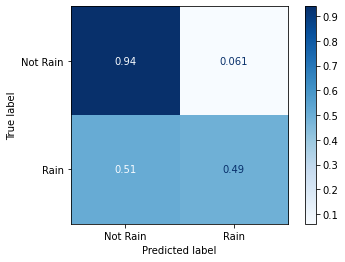

In [ ]:
plot_cm(model, X_test, y_test)

Como ya lo habíamos visto en los reportes anteriores, no tiene una buena precisión al clasificar 'Rain'

In [ ]:
f1_score(y_test, y_pred)

0.5763637705765114

Obteniendo una métrica para **F1-score de 57%**, el cual es nuestra medida base. <br>

Como una análisis más, revisaré cuales son las características que más contribuyen al modelo.

In [ ]:
def importance_attributes_logistic(data: pd.DataFrame, model):
    """Returns a dataframe with feature of importance by any model
    and their coefficients if the features were used in training
    logistic regression model"""
    df = pd.DataFrame()
    df['Feature'] = data.columns
    df['Importance'] = model.coef_[0]
    df.loc[df['Importance'] < 0, 'Sign'] = '-'
    df.loc[df['Importance'] >= 0, 'Sign'] = '+'
    df['Importance'] = abs(df['Importance'])
    
    df = df.sort_values('Importance', ascending=False)

    return df[['Feature', 'Sign', 'Importance']].reset_index(drop=True)

In [ ]:
df = importance_attributes_logistic(X_train, model)

**Top 10 de atributos con mayor relevancia dentro del modelo base**

In [ ]:
df.head(10)

,Feature,Sign,Importance
0,Humidity3pm,+,1.087223
1,WindGustSpeed,+,0.642866
2,WindDir3pm_NNW,+,0.493016
3,WindDir3pm_NW,+,0.429818
4,WindDir9am_NNE,+,0.412519
5,WindDir3pm_N,+,0.407570
6,Pressure9am,-,0.332538
7,Sunshine,-,0.290749
8,WindDir3pm_NNE,+,0.262195
9,Cloud3pm,+,0.246566


Ahora me gustaría presentar una prueba y un modelo sin considerar las variables: 'Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am', las cuáles tienen un 35% de datos faltantes, además de que el % de datos faltantes ha aumentado con el tiempo.

### Modelo A: eliminando atributos con más del 35% de datos nulos

In [ ]:
# Columnas a eliminar antes del modelado
drop_columns = ['MinTemp', 'Pressure3pm', 'Temp9am', 'Temp3pm', # Multicolineadlidad
                'Location', 'Date', 'month', 'year', # Sin importancia para el modelo
                'month_cos', # tiene mejor desempeño month_sin,
                # 'Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am' # >35% datos faltantes
                
               ]

In [ ]:
X_train, y_train, X_test, y_test = pipline_process_data(drop_columns)

In [ ]:
X_train = X_train.drop(columns=['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am'])
X_test = X_test.drop(columns=['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am'])

In [ ]:
model_A = LogisticRegression(random_state=0)
model_A.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
print(classification_report(y_train, model_A.predict(X_train)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     82736
           1       0.71      0.47      0.57     23908

    accuracy                           0.84    106644
   macro avg       0.78      0.71      0.73    106644
weighted avg       0.83      0.84      0.83    106644



In [ ]:
y_pred = model_A.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     27580
           1       0.69      0.47      0.56      7969

    accuracy                           0.83     35549
   macro avg       0.78      0.70      0.73     35549
weighted avg       0.82      0.83      0.82     35549



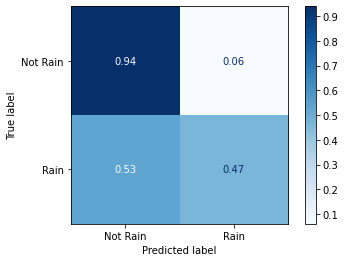

In [ ]:
plot_cm(model_A, X_test, y_test)

Como ya lo habíamos visto en los reportes anteriores, no tiene una buena precisión al clasificar 'Rain'

In [ ]:
f1_score(y_test, y_pred)

0.5586475164572112

La precisión se mantuvo similar al modelo anterior, por lo que por ahora no es viable eliminar las variables: ['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']

## RFE

Ahora utilizaré la Eliminación Recursiva de Características para disminuir la dimensionalidad del conjunto de datos y evaluar si existe alguna mejora en el modelo

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [ ]:
X_train, y_train, X_test, y_test = rain.pipline_process_data(drop_columns)

In [ ]:
logreg = LogisticRegression()
# Seleccionará la mitad de características, ya que el valor
# por defautl para n_features_to_select es 'None'
rfe = RFE(logreg)
rfe = rfe.fit(X_train, y_train.values.ravel())
# print(rfe.support_)
# print(rfe.ranking_)

In [ ]:
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_test_rfe = X_test[X_test.columns[rfe.support_]]

In [ ]:
X_train.shape

(106644, 59)

In [ ]:
X_test_rfe.shape

(35549, 29)

El número de características iniciales eran 60, y después de aplicar RFE, quedan 30. 

In [ ]:
model = LogisticRegression(random_state=0)

In [ ]:
model.fit(X_train_rfe, y_train)

LogisticRegression(random_state=0)

In [ ]:
print(classification_report(y_train, model.predict(X_train_rfe)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     82736
           1       0.71      0.49      0.58     23908

    accuracy                           0.84    106644
   macro avg       0.79      0.72      0.74    106644
weighted avg       0.83      0.84      0.83    106644



In [ ]:
y_pred = model.predict(X_test_rfe)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     27580
           1       0.70      0.49      0.57      7969

    accuracy                           0.84     35549
   macro avg       0.78      0.71      0.74     35549
weighted avg       0.83      0.84      0.83     35549



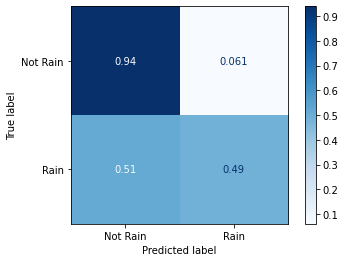

In [ ]:
plot_cm(model, X_test_rfe, y_test)

Como ya lo habíamos visto en los reportes anteriores, no tiene una buena precisión al clasificar 'Rain'

In [ ]:
f1_score(y_test, y_pred)

0.5733520751646075

## Eliminando variables categóricas con alta cardinalidad

In [ ]:
# Columnas a eliminar antes del modelado
drop_columns = ['MinTemp', 'Pressure3pm', 'Temp9am', 'Temp3pm', # Multicolineadlidad
                'WindGustDir', 'WindDir9am', 'WindDir3pm', # Alta cardinalidad
                'Location', 'Date', 'month', 'year', # Sin importancia para el modelo
                'month_cos', # tiene mejor desempeño month_sin,
                # 'Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am' # >35% datos faltantes
                
               ]

In [ ]:
X_train, y_train, X_test, y_test = pipline_process_data(drop_columns)

In [ ]:
X_train.shape

(106644, 14)

In [ ]:
X_train.head(2)

,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,month_sin,RainToday_Yes
45,1.445476,-0.441505,-0.095563,0.173866,0.381396,0.772517,1.240342,-1.991449,-1.208374,-1.546070,0.154836,0.128999,0.692809,0
123922,-0.280233,-0.441505,-0.095563,0.173866,-0.564591,-0.581357,-0.702506,0.381944,-0.538072,-0.013757,0.154836,0.128999,1.212339,0


In [ ]:
model = LogisticRegression(random_state=0)

In [ ]:
model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     82736
           1       0.71      0.48      0.57     23908

    accuracy                           0.84    106644
   macro avg       0.79      0.71      0.74    106644
weighted avg       0.83      0.84      0.83    106644



In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     27580
           1       0.70      0.48      0.57      7969

    accuracy                           0.84     35549
   macro avg       0.78      0.71      0.74     35549
weighted avg       0.83      0.84      0.83     35549



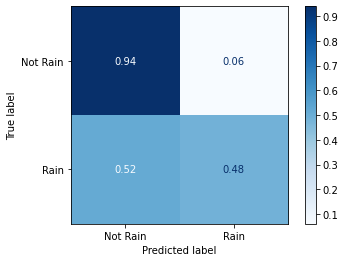

In [ ]:
plot_cm(model, X_test, y_test)

Como ya lo habíamos visto en los reportes anteriores, no tiene una buena precisión al clasificar 'Rain'

In [ ]:
f1_score(y_test, y_pred)

0.5712167272188032

In [ ]:
df = importance_attributes_logistic(X_train, model)

**Top de los atributos con mayor relevancia dentro del modelo base**

In [ ]:
df

,Feature,Sign,Importance
0,Humidity3pm,+,1.038549
1,WindGustSpeed,+,0.679781
2,Pressure9am,-,0.370516
3,Sunshine,-,0.288034
4,Cloud3pm,+,0.260363
5,WindSpeed3pm,-,0.234971
6,RainToday_Yes,+,0.183480
7,Rainfall,+,0.157966
8,MaxTemp,+,0.135096
9,WindSpeed9am,-,0.117558


### Aplicando RFE al modelo anterior

In [ ]:
logreg = LogisticRegression()
rfe = RFE(logreg, 10)
rfe = rfe.fit(X_train, y_train.values.ravel())

C:\PDN\venvs\venv_rain\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [ ]:
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_test_rfe = X_test[X_test.columns[rfe.support_]]

In [ ]:
X_train.shape

(106644, 14)

In [ ]:
X_test_rfe.shape

(35549, 10)

El número de características iniciales eran 15, y después de aplicar RFE, quedan 10. 

In [ ]:
model = LogisticRegression(random_state=0)

In [ ]:
model.fit(X_train_rfe, y_train)

LogisticRegression(random_state=0)

In [ ]:
print(classification_report(y_train, model.predict(X_train_rfe)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     82736
           1       0.71      0.48      0.57     23908

    accuracy                           0.84    106644
   macro avg       0.79      0.71      0.74    106644
weighted avg       0.83      0.84      0.83    106644



In [ ]:
y_pred = model.predict(X_test_rfe)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     27580
           1       0.70      0.48      0.57      7969

    accuracy                           0.84     35549
   macro avg       0.78      0.71      0.73     35549
weighted avg       0.83      0.84      0.83     35549



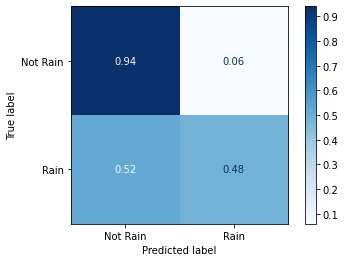

In [ ]:
plot_cm(model, X_test_rfe, y_test)

A continuación realizaré una prueba utilizando diferentes algotrimos de optimización. 

In [ ]:
df2 = pd.DataFrame()

for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    model = LogisticRegression(solver=solver, random_state=0)
    model.fit(X_train_rfe, y_train)
    
    y_pred_train = model.predict(X_train_rfe)
    f1_train = round(f1_score(y_train, y_pred_train) * 100, 4)
    
    y_pred_test = model.predict(X_test_rfe)
    f1_test = round(f1_score(y_test, y_pred_test) * 100, 4)
    
    df_tmp = pd.DataFrame([{'Model': solver,
                            'F1_train': f1_train,
                            'F1_test': f1_test}])
    
    df2 = df_tmp if df2.empty else pd.concat([df2, df_tmp])

    

In [ ]:
df2

,Model,F1_train,F1_test
0,newton-cg,57.4161,57.0048
0,lbfgs,57.4176,57.0048
0,liblinear,57.4197,57.0005
0,sag,57.4176,57.0048
0,saga,57.4197,56.9941


### Hiperparamétrización

In [ ]:
logreg_params = {
    'C': [1, 1e8, 1e16],
    'fit_intercept': [True, False],
    'max_iter': [50, 100, 150],
    'random_state': [0]
}

logreg_gs = GridSearchCV(logreg, logreg_params, scoring='f1', n_jobs=-1, cv=5)
logreg_gs.fit(X_train_rfe, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 100000000.0, 1e+16],
                         'fit_intercept': [True, False],
                         'max_iter': [50, 100, 150], 'random_state': [0]},
             scoring='f1')

In [ ]:
logreg_gs.best_params_

{'C': 1, 'fit_intercept': True, 'max_iter': 50, 'random_state': 0}

In [ ]:
round(logreg_gs.best_score_, 4)

0.5742

In [ ]:
y_pred_logreg_gs = logreg_gs.predict(X_test_rfe)
y_pred_logreg_gs

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [ ]:
print(classification_report(y_train, logreg_gs.predict(X_train_rfe)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     82736
           1       0.71      0.48      0.57     23908

    accuracy                           0.84    106644
   macro avg       0.79      0.71      0.74    106644
weighted avg       0.83      0.84      0.83    106644



In [ ]:
y_pred = model.predict(X_test_rfe)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     27580
           1       0.70      0.48      0.57      7969

    accuracy                           0.84     35549
   macro avg       0.78      0.71      0.73     35549
weighted avg       0.83      0.84      0.83     35549



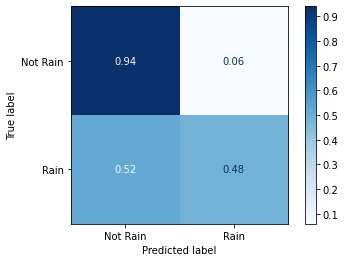

In [ ]:
plot_cm(model, X_test_rfe, y_test)

In [ ]:
f1_score(y_test, y_pred)

0.5699412508366178

## Conclusiones

- El modelo en general no ha tenido mejoras, por lo que en este punto no tiene sentido realizar un ajuste en los hipérparametros. 
- Es necesario mejorar el análisis de las variables
- Podría ser conveniente conocer más sobre la distribución de la precipitación en Australia
- El modelo podría mejorar si se realiza con un enfoque local (una ciudad) o regional (algunas ciudades)
- Podría mejorar el modelo al utilizar otro tipos de normalización

En el siguiente notebook realizaré otras pruebas con otros algoritmos para conocer el desempeño de otros modelos de clasificación.